In [1]:
# cant use any of this, since it 

from vpython import *

scene1=canvas(background = color.black, width=600, length=600, center=vector(0,0,0))


x = sphere(radius = 0.1)

print(x.radius)

# pointer_x = arrow(pos=vector(0,0,0),axis = vector(1,0,0),shaft_width = 0.5,color=color.red)
# pointer_y = arrow(pos=vector(0,0,0),axis = vector(0,1,0),shaft_width = 0.5,color=color.green)
# pointer_y = arrow(pos=vector(0,0,0),axis = vector(0,0,1),shaft_width = 0.5,color=color.blue)

ModuleNotFoundError: No module named 'vpython'

In [6]:
import stl
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

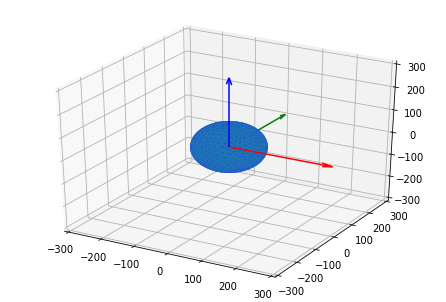

In [144]:
def plot_stl(stl_file):
    figure = plt.figure()
    axes = mplot3d.Axes3D(figure)
    
    axes.add_collection3d(mplot3d.art3d.Poly3DCollection(stl_file.vectors,edgecolors='b',linewidth=0.05))
    scale = stl_file.points.flatten('C')
    axes.auto_scale_xyz(scale,scale,scale)
    plt.show()

figure = plt.figure()
axes = mplot3d.Axes3D(figure)

# Load the STL files and add the vectors to the plot
your_mesh = mesh.Mesh.from_file("stl_data/unit_circle_radius_100_binary.stl")
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(your_mesh.vectors,edgecolors='b',linewidths=0.05))

# Auto scale to the mesh size
scale = your_mesh.points.flatten('C')
axes.auto_scale_xyz(scale, scale, scale)
axes.set_xlim3d(left=-300,right=300)
axes.set_ylim3d(bottom=-300,top=300)
axes.set_zlim3d(bottom=-300,top=300)

axes.set_xmargin(1)
axes.set_ymargin(1)
axes.set_zmargin(1)
axes.scatter(0,0,0,s=200,c='r',marker='o')
x, y, z = np.zeros((3,3))
ux, vx, wx = np.array([[1,0,0],[0,0,0],[0,0,0]])*300
uy, vy, wy = np.array([[0,0,0],[0,1,0],[0,0,0]])*300
uz, vz, wz = np.array([[0,0,0],[0,0,0],[0,0,1]])*300

print
axes.quiver(x,y,z,ux,vx,wx,arrow_length_ratio=0.1,color='r')
axes.quiver(x,y,z,uy,vy,wy,arrow_length_ratio=0.1,color='g')
axes.quiver(x,y,z,uz,vz,wz,arrow_length_ratio=0.1,color='b')


# Show the plot to the screen
plt.show()


#### Converting to ascii for from a high resolution sphere(at expense of file space)

In [8]:
your_mesh.save("stl_data/ascii_3d_sphere.stl",mode=stl.Mode.ASCII)

import numpy as np

#### adding multiple sphere together

In [113]:
import numpy as np

# functions for combine two different stl
# find the max dimensions, so we can know the bounding box, getting the height,
# width, length (because these are the step size)...
def find_mins_maxs(obj):
    minx = maxx = miny = maxy = minz = maxz = None
    for p in obj.points:
        # p contains (x, y, z)
        if minx is None:
            minx = p[stl.Dimension.X]
            maxx = p[stl.Dimension.X]
            miny = p[stl.Dimension.Y]
            maxy = p[stl.Dimension.Y]
            minz = p[stl.Dimension.Z]
            maxz = p[stl.Dimension.Z]
        else:
            maxx = max(p[stl.Dimension.X], maxx)
            minx = min(p[stl.Dimension.X], minx)
            maxy = max(p[stl.Dimension.Y], maxy)
            miny = min(p[stl.Dimension.Y], miny)
            maxz = max(p[stl.Dimension.Z], maxz)
            minz = min(p[stl.Dimension.Z], minz)
    return minx, maxx, miny, maxy, minz, maxz

def find_obj_size(obj):
    minx,maxx,miny,maxy,minz,maxz = find_mins_maxs(obj)
    x = abs(maxx - minx)
    y = abs(maxy - miny)
    z = abs(maxz - minz)
    return x,y,z

def translate(_solid, step, padding, multiplier, axis):
    if 'x' == axis:
        items = 0, 3, 6
    elif 'y' == axis:
        items = 1, 4, 7
    elif 'z' == axis:
        items = 2, 5, 8
    else:
        raise RuntimeError('Unknown axis %r, expected x, y or z' % axis)

    # _solid.points.shape == [:, ((x, y, z), (x, y, z), (x, y, z))]
    _solid.points[:, items] += (step * multiplier) + (padding * multiplier)

### copy objects and also translating it
def copy_objs(obj, dims, num_rows, num_cols, num_layers):
    # obj = copy object
    # dims = tuple of x y and z of the translating distance
    # num_rows = number of in x direction
    # num_cols = number of copy in y direction
    # 
    w, l, h = dims
    copies = []
    for layer in range(num_layers):
        for row in range(num_rows):
            for col in range(num_cols):
                # skip the position where original being copied is
                if row == 0 and col == 0 and layer == 0:
                    continue
                _copy = mesh.Mesh(obj.data.copy())
                # pad the space between objects by 10% of the dimension being
                # translated
                if col != 0:
                    translate(_copy, w, w / 10., col, 'x')
                if row != 0:
                    translate(_copy, l, l / 10., row, 'y')
                if layer != 0:
                    translate(_copy, h, h / 10., layer, 'z')
                copies.append(_copy)
    return copies

### Copy the objects 
def copy_obj(obj,dims):
    # x,y,z
    w,l,h = dims
    _copy = mesh.Mesh(obj.data.copy())
    # translate x
    translate(_copy, w, w / 10., 1, 'x')
    # translate y
    translate(_copy, l, l / 10., 1, 'y')
    # translate z
    translate(_copy, h, h / 10., 1, 'z')
    return(_copy)

# Scale object using rotation matrix
def scale_obj(obj,scale):
    scale_mat = np.identity(3)*scale
    stl.mesh.Mesh.rotate_using_matrix(obj,scale_mat)

def copy_scale_obj(obj,dims,scale):
    _copy = copy_obj(obj,dims)
    scale_obj(_copy,scale)
    
    return _copy
    

341.58032 331.80518 331.80518


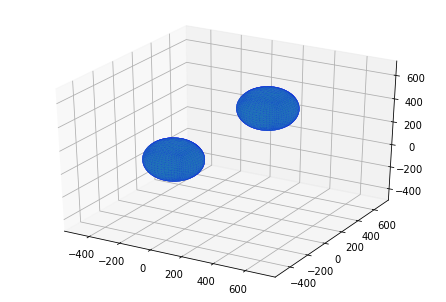

In [70]:

###  Check List
# output x y z coordinates
# load in files
# 

main_body = mesh.Mesh.from_file('stl_data/ascii_3d_sphere.stl')
  
# find the max values
minx, maxx, miny, maxy, minz, maxz = find_mins_maxs(main_body)

main_body_2 = mesh.Mesh.from_file('stl_data/ascii_3d_sphere.stl')


x,y,z =find_obj_size(main_body_2)

print(x,y,z)

# translate(main_body_2,w2,w2/10.,3,'x')
# translate(main_body_2,w2,w2/10.,3,'x')


copy_1 = copy_objs(main_body,(x,y,z),1,1,2)

copy_2 = copy_obj(main_body,(x,y,z))


### Combined
#combined = mesh.Mesh(np.concatenate([main_body.data]+[i.data for i in copy_1]))
combined = mesh.Mesh(np.concatenate([main_body.data,copy_2.data]))

# saving data
plot_stl(combined)
combined.save('stl_data/stl_test/combine_test.stl',mode=stl.Mode.ASCII)

[[0.5 0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0.5]]


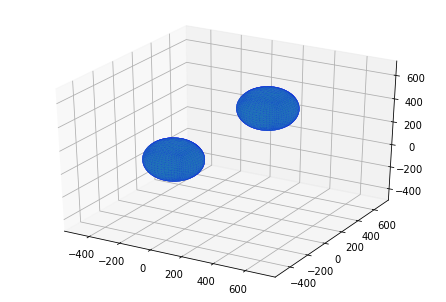

In [111]:
# two sphere of varying diameter

sphere_1 = mesh.Mesh.from_file('stl_data/ascii_3d_sphere.stl')
sphere_2 = mesh.Mesh.from_file('stl_data/ascii_3d_sphere.stl')

rot_mat = np.identity(3)*0.5

print(rot_mat)

# stl.mesh.Mesh.rotate_using_matrix(sphere_1,rot_mat)

copy_2 = copy_obj(sphere_1,(x,y,z))
scale_obj(copy_2,1)

combined = mesh.Mesh(np.concatenate([sphere_1.data,copy_2.data]))
plot_stl(combined)

28


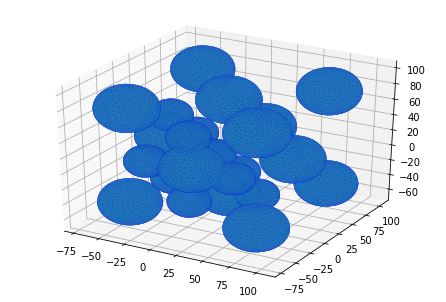

In [149]:
# Mesh


coord = np.genfromtxt('nacl_v1_coord.csv',delimiter=',')

sphere = mesh.Mesh.from_file('stl_data/unit_circle_radius_100_binary.stl')
x_len,y_len,z_len =find_obj_size(sphere)

# append the list
item_list = []
for i in range(len(coord)):
    obj_coord = ((coord[i,0]+coord[i,3])*x_len,(coord[i,1]+coord[i,3])*y_len,(coord[i,2]+coord[i,3])*z_len)
#     print(obj_coord)
    obj = copy_scale_obj(sphere,obj_coord,coord[i,3])
    item_list.append(obj)

print(len(item_list))
# combine and output s stl   
combined = mesh.Mesh(np.concatenate([i.data for i in item_list]))
plot_stl(combined)
combined.save('stl_data/stl_test/multi_varying_size.stl',mode=stl.Mode.ASCII)